# TMS/EEG Visualization from MATLAB Figures

This is a guide for creating those cool animations we all love when all you have is the figure you saved out from doing the analysis in MATLAB.  There's a better way to do this but I don't know what it is yet.

## 1. Extracting the data from the fig

This part is in MATLAB.  
* First you need to open up the `<Channel> Evoked EEG.fig` file with MATLAB.
* Click the "Show Plot Tools and Dock Figure" icon in the dock -- should be the farthest right icon.
* Click on the time series, the upper part of the figure with the colorful lines -- not the circle with the topography.

Now run the following MATLAB code: 
```MATLAB
    D=get(gca,'Children'); %get the handle of the line object
    XData=get(D,'XData'); %get the x data
    YData=get(D,'YData'); %get the y data
    XMat = cell2mat(XData)
    YMat = cell2mat(YData)
    csvwrite('filenameX.dat', XMat)
    csvwrite('filenameY.dat', YMat)
```

Name the files whatever you like, but I'm going to use `F3_post_X.dat` and `F3_post_Y.dat`.
* `F3_post_X.dat` is a CSV file with dimensions: `number_of_channels` x `number_of_timepoints`, the contents of each element are the timepoint.  This is redundant because all channels obviously were recorded at the same timepoints, so we'll only use the first row as you'll see.
* `F3_post_Y.dat` is a CSV file with the same dimensions, except each row corresponds to an electrode of the EEG in the **reverse** order they're listed in the montage file.

**Make sure to copy over the montage file:** should be something like `brainampnew.sfp` which is what I'm using here.

## 2. Making the visualizations with Python

In [1]:
import mne
import numpy as np
import os
import os.path as op
import matplotlib.pyplot as plt

Set the `datadir` and read in the montage file.

In [2]:
datadir = '/home/chris/Projects/MNE-2017/data/'
montage = mne.channels.read_montage(kind='brainampnew', path=datadir)

Read in the X and Y data.  Remember we only need the first row of the X data (timepoints are all the same) and we have to reverse the order of the Y data.

In [3]:
xdata = np.genfromtxt(op.join(datadir, 'F3_post_X.dat'), delimiter=',')
times = xdata[0,:]
ydata = np.genfromtxt(op.join(datadir, 'F3_post_Y.dat'), delimiter=',')
ydata = np.flip(ydata, 0)

Now create the [`mne.EvokedArray`](http://www.nmr.mgh.harvard.edu/mne/dev/generated/mne.EvokedArray.html) object we'll use to save this out to a file.  (Ideally this wouldn't be necessary, but I don't see another way to create the [`mne.Evoked`](http://martinos.org/mne/dev/generated/mne.Evoked.html) object without reading it from a file.)

In [4]:
eeg_type_list = ['eeg' for i in range(62)]
info = mne.create_info(ch_names=montage.ch_names, sfreq=625, ch_types=eeg_type_list)
evokedarray = mne.EvokedArray(data=ydata, info=info, kind='average')
evokedarray.save('F3_numpy-ave.fif')

Now create that `Evoked` object by reading it back in.  

In [5]:
evoked = mne.Evoked(fname='F3_numpy-ave.fif')
evoked.set_montage(montage)
evoked.times = times

Isotrak not found
    Found the data of interest:
        t =       0.00 ...    1200.00 ms (No comment)
        0 CTF compensation matrices available
        nave = 1 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.


At this point we can start plotting stuff to make sure things look all right.

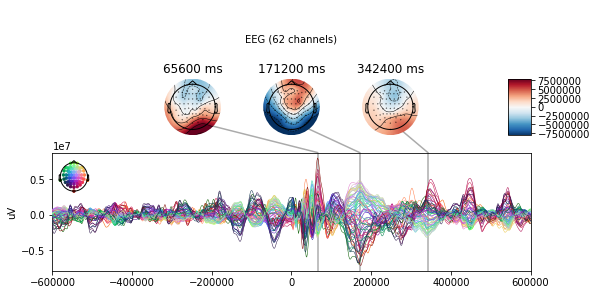

In [6]:
evoked.plot_joint(times='peaks', show=False)

Now we create a few data structures that will let us make topographic maps more descriptive.
This is an array which specifies where and when to add a marker on the topography, which we'll use to denote the stimulation site.

In [7]:
f3_mask_bool = np.zeros((evoked.info['nchan'], len(times))).astype(bool)
f3_mask_bool[evoked.ch_names.index('F3'), :] = True
f3_mask_param = {'marker': '*', 
                 'markerfacecolor': 'm', 
                 'markeredgecolor': 'k', 
                 'linewidth': 1, 
                 'markersize': 15}

## 3. Making the animation

First we create the directory we'll put the figures in for the animation.

In [8]:
os.mkdir(op.join(datadir, 'F3_animation'))

And let's go ahead and create one of our frames and see if we like how it looks.

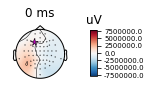

In [9]:
evoked.plot_topomap(times=[0.0], ch_type='eeg', 
                    vmin=-8000000.0, vmax=8000000.0, 
                    show=False, 
                    mask=f3_mask_bool, mask_params=f3_mask_param)

Looks fine from here.  Let's make one of these for each time point.

In [10]:
i = 0
for time in times:
    fig = evoked.plot_topomap(times=time, ch_type='eeg', 
                              vmin=-8000000.0, vmax=8000000.0, 
                              show=False, 
                              mask=f3_mask_bool, mask_params=f3_mask_param)
    fig.savefig(filename=op.join(datadir, 'F3_animation', 'image-{:04d}.png').format(i), dpi=200)
    i = i+1
    plt.close(fig)

Now stitch it together with a bash command like:
```bash
ffmpeg -i datadir/F3_animation/image-%04d.png -vcodec huffyuv ../F3_animation.avi
```